# Assignment 6

Firstly, we load numerical and plotting libraries:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Plotting defaults (clean, readable)
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
})

## Parameters

Here we introduce some parameters, that we will use throughout the assignment:

- `N` is the lattice width/height (we choose it to be odd so the centre is an integer cell).
- `num_walkers` controls how many independent walkers we shoot for histograms.
- `msd_walkers` is a (possibly smaller) group for the MSD computation.
- `steps_list` are the walk lengths we will visualise.
- `boundary` chooses **reflecting** or **periodic** conditions; we use the same in RW and diffusion.
- `use_continuum_D=True` enforces the mapping between RW and diffusion: identify time with steps (`t=n`) and set \(D=\tfrac14\) so that \(\langle r^2\rangle=4Dt=n\). If `False`, we use \(D=1\) and compare at \(t=n/4\).
- `dt` is the FTCS time step. The assertion enforces the 2D stability condition \(D\,\Delta t\le 1/4\) (with spacing \(h=1\)).

In [11]:
# --- Core parameters ---
N = 201                 # Lattice size (odd preferred so the center is an integer cell)
num_walkers = 20000     # Number of independent walkers for histograms
msd_walkers = 8000      # Number of walkers used for MSD vs n
steps_list = [50, 100, 200]  # Walk lengths to visualise

boundary = "reflect"    # 'reflect' or 'periodic' (use the SAME for RW and diffusion)

# --- Diffusion and time-step parameters ---
use_continuum_D = True  # If True, use D=1/4 and compare at t=n; else use D=1 and compare at t=n/4
D = 0.25 if use_continuum_D else 1.0

# FTCS stability in 2D with spacing h=1 requires lambda = D*dt <= 1/4
dt = 0.2                # Choose dt such that D*dt <= 0.25
assert D * dt <= 0.25 + 1e-12, "Unstable FTCS parameters: increase stability by lowering dt."

# --- Reproducibility ---
rng = np.random.default_rng(0)

## Implementing random walk

In order to implement a random walk, we encode each direction $\{\uparrow,\downarrow,\rightarrow,\leftarrow\}$ as an integer $\{1,2,3,4\}$ chosen uniformly at random.

> We could implement two boundary conditions:
  - *Periodic*: coordinates wrap with modulo $N$.
  - *Reflecting*: we mirror the step at the wall ("hard" reflection) to keep walkers inside the box.

In [3]:
# Helper for 'reflecting' boundaries

def _reflect_coords(arr, N):
    """Reflect out-of-bounds coordinates back into [0, N-1] with a hard-wall reflection.
    For x<0 -> 1, for x>=N -> N-2 (mirror the step). Works elementwise on an integer array.
    """
    # Below left wall: set to 1
    mask_lo = arr < 0
    if np.any(mask_lo):
        arr = arr.copy()
        arr[mask_lo] = 1
    # Beyond right wall: set to N-2
    mask_hi = arr >= N
    if np.any(mask_hi):
        arr = arr.copy()
        arr[mask_hi] = N - 2
    return arr

def rw_step_xy(x, y, boundary, rng):
    """One vectorised RW step for all walkers: updates x,y in-place (returns the new arrays).
    Directions: 0=up, 1=down, 2=right, 3=left.
    """
    # Random directions for each walker
    r = rng.integers(0, 4, size=x.shape)
    # Move: booleans cast to 0/1
    x = x + (r == 2) - (r == 3)
    y = y + (r == 0) - (r == 1)

    if boundary == "periodic":
        x %= N
        y %= N
    elif boundary == "reflect":
        x = _reflect_coords(x, N)
        y = _reflect_coords(y, N)
    else:
        raise ValueError("boundary must be 'periodic' or 'reflect'")
    return x, y

## Plotting paths, and Mean Square Distance

We would like to check that the Mean Square Distance obeys the relation

$$ \langle d^2\rangle = D\,n, $$

and compute $D$.

To this end, we introduce two functions:
- `simulate_walks(steps, M, ...)`: run `M` walkers for `steps` steps from the centre.
- `msd_vs_n(...)`: compute the Mean Square Distance $\langle r^2\rangle$ against the step count and fit a line for the large-$n$ slope.

In [4]:
def simulate_walks(steps, M, boundary, rng):
    """Simulate M walkers for steps steps from the lattice centre."""
    cx = cy = N // 2
    x = np.full(M, cx, dtype=int)
    y = np.full(M, cy, dtype=int)
    for _ in range(steps):
        x, y = rw_step_xy(x, y, boundary, rng)
    return x, y

def msd_vs_n(n_max=1000, M=5000, boundary="reflect", rng=None):
    """Compute MSD as a function of step number up to n_max; also return a slope fit."""
    if rng is None:
        rng = np.random.default_rng(0)
    cx = cy = N // 2
    x = np.full(M, cx, dtype=int)
    y = np.full(M, cy, dtype=int)
    msd = np.zeros(n_max + 1, dtype=float)

    for n in range(1, n_max + 1):
        x, y = rw_step_xy(x, y, boundary, rng)
        dx = x - cx
        dy = y - cy
        msd[n] = np.mean(dx*dx + dy*dy)

    # Fit a straight line to the large-n regime to estimate the slope
    n_arr = np.arange(n_max + 1)
    lo = max(1, int(0.1 * n_max))  # avoid very small n
    A = np.vstack([n_arr[lo:], np.ones(n_max + 1 - lo)]).T
    slope, intercept = np.linalg.lstsq(A, msd[lo:], rcond=None)[0]
    return n_arr, msd, slope, intercept


...and we plot the Mean Square Distance against the number of steps, and compute the parameter $D$:

Estimated D from MSD slope (RW units): D ≈ 0.9987  (theory: 1.0)


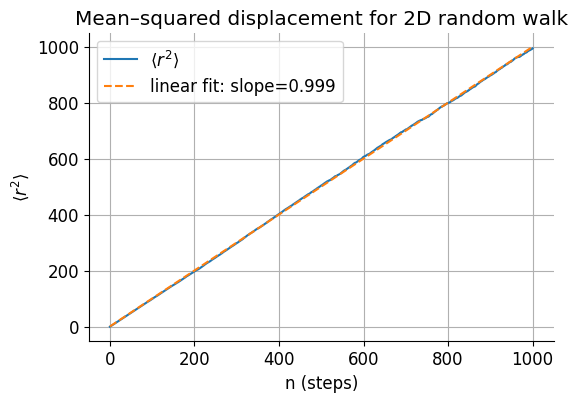

In [5]:
# --- Parameters ---
N = 201                 # Lattice size (odd preferred so the center is an integer cell)
num_walkers = 20000     # Number of independent walkers for histograms
msd_walkers = 8000      # Number of walkers used for MSD vs n


boundary = "reflect"    # 'reflect' or 'periodic' (use the SAME for RW and diffusion)


n, msd, slope, intercept = msd_vs_n(n_max=1000, M=msd_walkers, boundary=boundary, rng=np.random.default_rng(123))
print(f"Estimated D from MSD slope (RW units): D ≈ {slope:.4f}  (theory: 1.0)")

plt.figure()
plt.plot(n, msd, label=r"$\langle r^2 \rangle$")
plt.plot(n, slope*n + intercept, "--", label=f"linear fit: slope={slope:.3f}")
plt.xlabel("n (steps)")
plt.ylabel(r"$\langle r^2 \rangle$")
plt.title("Mean–squared displacement for 2D random walk")
plt.legend()
plt.show()

## Distribution of the endpoints

We would like to investigate what is the empirical distribution of end positions after a given number of steps $n$, for several values of $n$.

To this aim, for each `steps` in `steps_list`, we simulate some random walkers and put in a 2D histogram their end positions:

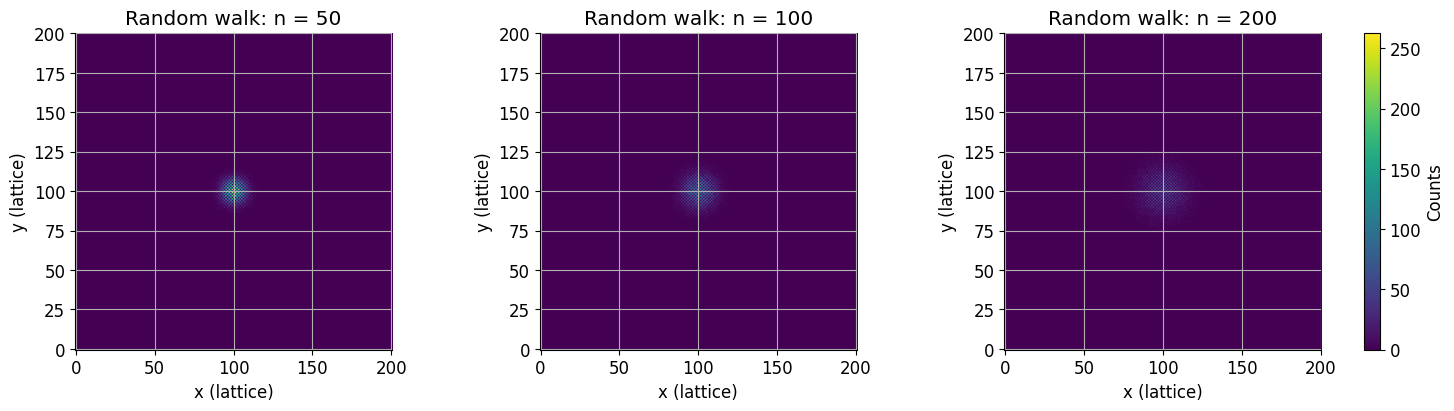

In [12]:
# --- Helper function for obtaining the 2D histograms ---
def histogram2d_from_walks(xs, ys, N):
    H, xedges, yedges = np.histogram2d(xs, ys, bins=N, range=[[0, N], [0, N]])
    return H.T  # imshow expects [y,x] with origin='lower'

# --- Plot ---
# Slightly complicated - but it nicely puts all the plots in a single image!

Hs = []
for steps in steps_list:
    xs, ys = simulate_walks(steps, num_walkers, boundary, rng=np.random.default_rng(0))
    Hs.append((steps, histogram2d_from_walks(xs, ys, N)))

# Shared color scale 
vmax = max(H.max() for _, H in Hs)
vmin = 0.0

fig, axs = plt.subplots(1, len(Hs), figsize=(5 * len(Hs), 4), constrained_layout=True)
if len(Hs) == 1:
    axs = [axs]  # make it iterable when there's only one steps value

ims = []
for ax, (steps, H) in zip(axs, Hs):
    im = ax.imshow(H, origin="lower", vmin=vmin, vmax=vmax)
    ax.set_title(f"Random walk: n = {steps}")
    ax.set_xlabel("x (lattice)")
    ax.set_ylabel("y (lattice)")
    ims.append(im)

# One shared colorbar for all panels
cbar = fig.colorbar(ims[-1], ax=axs, fraction=0.046, pad=0.02)
cbar.set_label("Counts")
plt.show()


## Studying diffusion equation via the FTCS method

We would like to solve the diffusion 2D partial differential equation solves 

$$ \partial_t\phi = D(\partial_{x}^2\phi + \partial_{y}^2\phi) $$

by using the **FTCS (forward-time centered-space) method**. According to this method, on a square grid with spacing $a=1$, at each step, we set

$$ \phi^{n+1}_{i,j} = \phi^{n}_{i,j} + \lambda\,(\phi^{n}_{i+1,j}+\phi^{n}_{i-1,j}+\phi^{n}_{i,j+1}+\phi^{n}_{i,j-1}-4\phi^{n}_{i,j}),$$

with $\lambda=D\,\Delta t$. Stability in 2D requires $\lambda\le \frac 14$.

A function implementing the method is:

In [13]:
def ftcs_diffuse(T_steps, D, dt, bc):
    """Solve phi_t = D (phi_xx + phi_yy) on an N x N grid (spacing h=1).
    Initial condition: discrete delta at the centre (unnormalised).
    Returns the field phi at time t = T_steps*dt.
    """
    lam = D * dt
    if lam > 0.25 + 1e-12:
        raise ValueError("Unstable FTCS parameters: need D*dt <= 1/4 for a=1 in 2D.")

    phi = np.zeros((N, N), dtype=float)
    cx = cy = N // 2
    phi[cy, cx] = 1.0

    for _ in range(T_steps):
        if bc == "periodic":
            up    = np.roll(phi, -1, axis=0)
            down  = np.roll(phi, +1, axis=0)
            right = np.roll(phi, -1, axis=1)
            left  = np.roll(phi, +1, axis=1)
        elif bc == "reflect":
            # copy-neighbour reflection on the edges
            up = np.empty_like(phi);    up[:-1, :] = phi[1:, :];   up[-1, :]  = phi[-2, :]
            down = np.empty_like(phi);  down[1:, :] = phi[:-1, :]; down[0, :] = phi[1, :]
            right = np.empty_like(phi); right[:, :-1] = phi[:, 1:]; right[:, -1] = phi[:, -2]
            left = np.empty_like(phi);  left[:, 1:] = phi[:, :-1];  left[:, 0]  = phi[:, 1]
        else:
            raise ValueError("boundary condition must be 'periodic' or 'reflect'")

        phi = phi + lam * (up + down + left + right - 4.0 * phi)

    return phi

We now simulate the FTCS solution starting from a **delta-like** initial condition,
$$
\phi(x,y,0)=0 \quad \text{everywhere except at the centre } (L/2,L/2), \text{ where } \phi>0,
$$
and compare it at time $t$ with the continuum **free-space** analytic solution
$$
G(x,y,t) = \frac{1}{4\pi D t}\,\exp\!\left(-\frac{x^2+y^2}{4 D t}\right).
$$


However, in order to compare the solutions obtained from solving the diffusion equation with the FTCS method and the analytic ones, and since the problem is symmetric in the angular direction, we can study the *radial distributions*.
Therefore, we introduce the following helper to recast the distributions as radial ones:

In [14]:
def radial_profile(arr):
    """Return a 1D radial profile (sum on circles) from the array centre."""
    cy = cx = arr.shape[0] // 2
    yy, xx = np.indices(arr.shape)
    rr = np.hypot(xx - cx, yy - cy).astype(int)
    rmax = min(cx, cy)
    prof = np.array([arr[rr == r].sum() for r in range(rmax)], dtype=float)
    return prof

On a large grid and for moderate times (so that boundaries are not yet “felt”), the FTCS field and the Gaussian
should match closely in their **radial profile**. We normalise both arrays to unit discrete mass before comparison.
To see this, let us plot them:

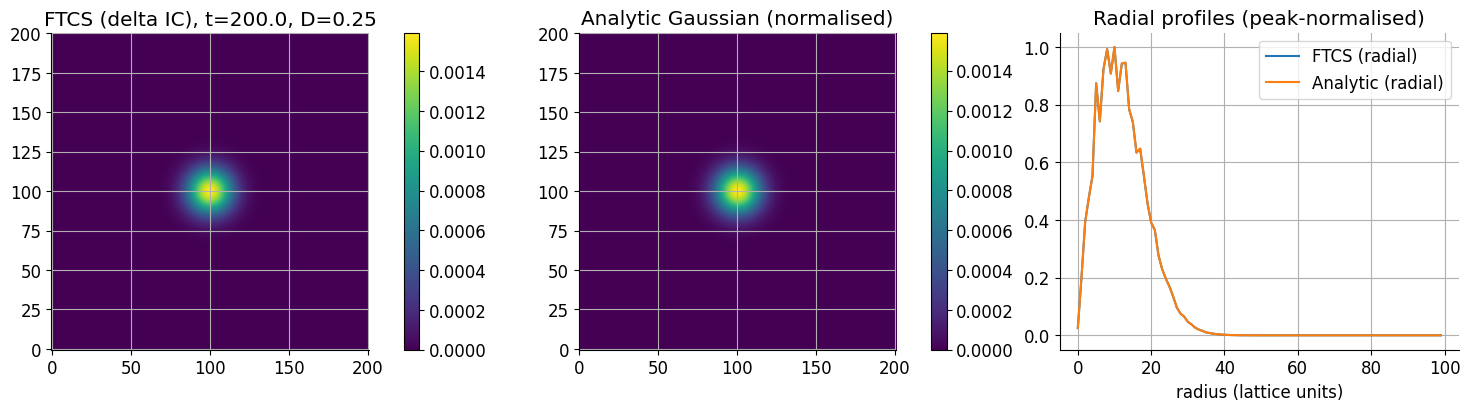

In [19]:
# --- Delta IC (FTCS) vs analytic Gaussian ---
t_compare = 200.0 if use_continuum_D else 50.0 # small enough to avoid boundary effects.
T_steps = int(round(t_compare / dt))

# FTCS evolve from a delta at the center (implemented inside ftcs_diffuse)
phi = ftcs_diffuse(T_steps, D=D, dt=dt, bc=boundary)

# Analytic Gaussian at the same time
cy = cx = N // 2
yy, xx = np.indices((N, N))
r2 = (xx - cx)**2 + (yy - cy)**2

def _gaussian_2d(r2, t, D):
    if t <= 0:
        return np.zeros_like(r2, dtype=float)
    return np.exp(-r2 / (4.0 * D * t)) / (4.0 * np.pi * D * t)

G = _gaussian_2d(r2, t_compare, D)

# Normalise both to the same discrete mass
phi_n = phi / max(phi.sum(), 1e-12)
G_n   = G   / max(G.sum(),   1e-12)

# Radial profiles (normalised to peak 1 for overlay)
prof_phi = radial_profile(phi_n)
prof_G   = radial_profile(G_n)
if prof_phi.max() > 0: prof_phi = prof_phi / prof_phi.max()
if prof_G.max()   > 0: prof_G   = prof_G   / prof_G.max()

# Plots: fields and radial overlay
fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

im0 = axs[0].imshow(phi_n, origin="lower")
axs[0].set_title(f"FTCS (delta IC), t={t_compare:.1f}, D={D}")
plt.colorbar(im0, ax=axs[0], fraction=0.046)

im1 = axs[1].imshow(G_n, origin="lower")
axs[1].set_title("Analytic Gaussian (normalised)")
plt.colorbar(im1, ax=axs[1], fraction=0.046)

axs[2].plot(prof_phi, label="FTCS (radial)")
axs[2].plot(prof_G,   label="Analytic (radial)")
axs[2].set_xlabel("radius (lattice units)")
axs[2].set_title("Radial profiles (peak-normalised)")
axs[2].legend()

plt.show()


## Diffusion equation and random walks



We can then plot the distributions of points obtained from the random walk, those obtained from solving the diffusion equation with the FTCS method, and compare the two radial distributions for some values of the final steps:

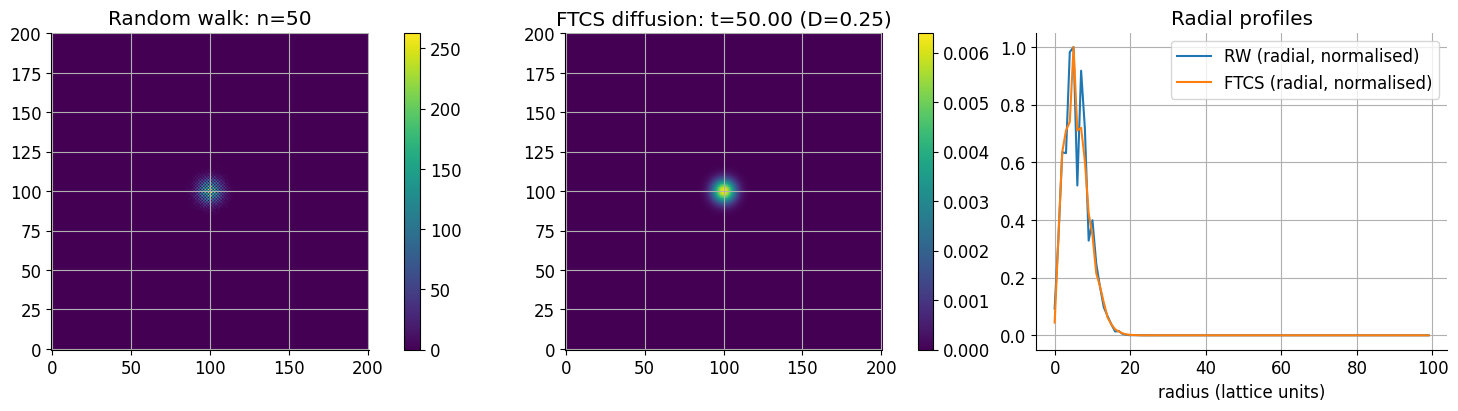

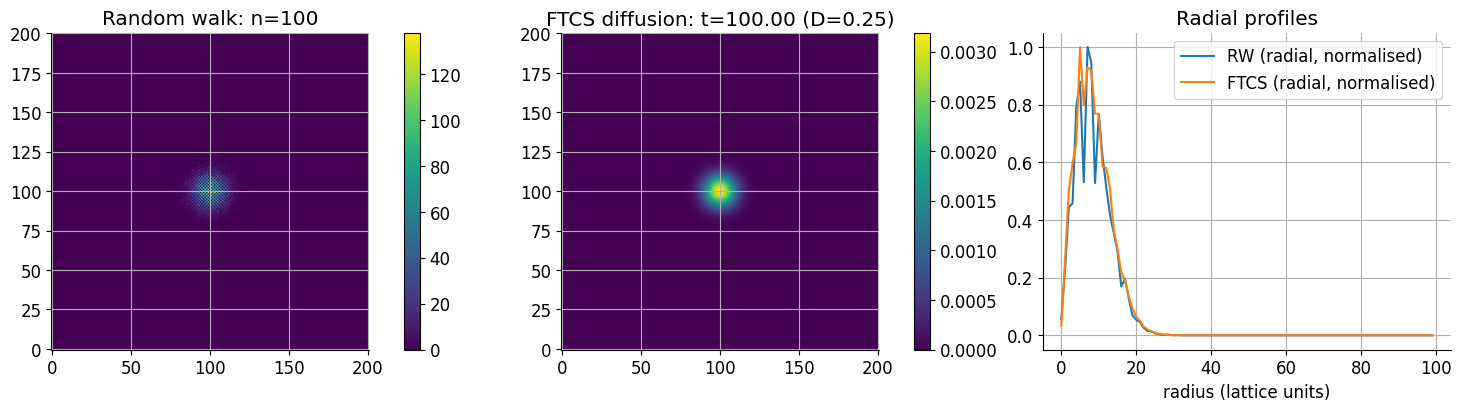

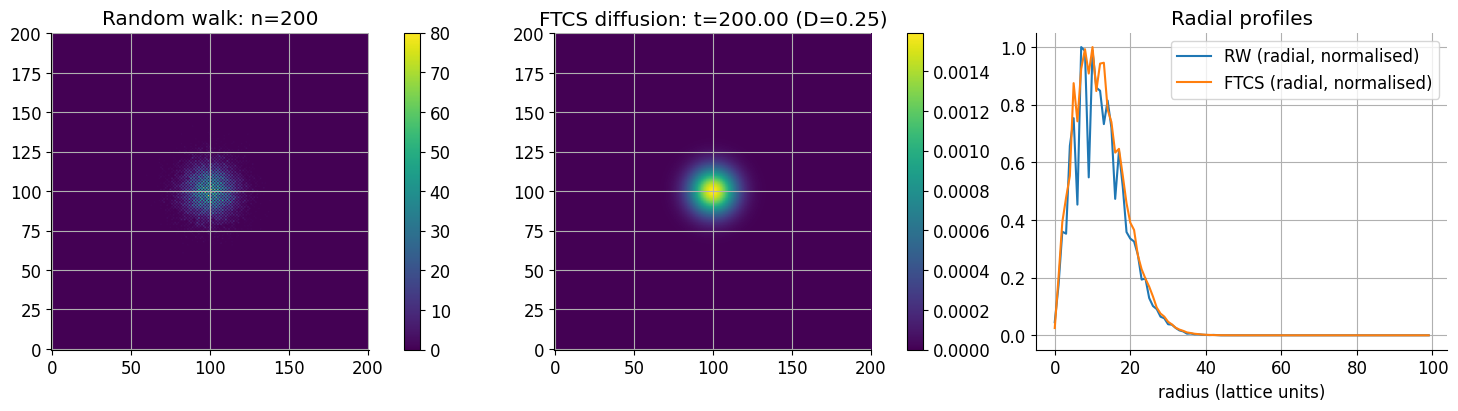

In [15]:
for steps in steps_list:
    # Random-walk histogram
    xs, ys = simulate_walks(steps, num_walkers, boundary, rng=np.random.default_rng(0))
    H = histogram2d_from_walks(xs, ys, N)

    # FTCS diffusion time mapping
    # If use_continuum_D: compare at t = n (so evolve for T_steps = n/dt)
    # Else: choose D=1 and compare at t = n/4  -> evolve for T_steps = (n/4)/dt
    t_compare = steps if use_continuum_D else steps / 4.0
    T_steps = int(round(t_compare / dt))
    phi = ftcs_diffuse(T_steps, D=D, dt=dt, bc=boundary)

    # Radial profiles (normalised)
    prof_rw = radial_profile(H);   prof_rw /= prof_rw.max() if prof_rw.max() > 0 else 1.0
    prof_phi = radial_profile(phi); prof_phi /= prof_phi.max() if prof_phi.max() > 0 else 1.0

    # Plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
    im0 = axs[0].imshow(H, origin="lower")
    axs[0].set_title(f"Random walk: n={steps}")
    plt.colorbar(im0, ax=axs[0], fraction=0.046)

    im1 = axs[1].imshow(phi, origin="lower")
    axs[1].set_title(f"FTCS diffusion: t={t_compare:.2f} (D={D})")
    plt.colorbar(im1, ax=axs[1], fraction=0.046)

    axs[2].plot(prof_rw, label="RW (radial, normalised)")
    axs[2].plot(prof_phi, label="FTCS (radial, normalised)")
    axs[2].set_xlabel("radius (lattice units)")
    axs[2].set_title("Radial profiles")
    axs[2].legend()
    plt.show()
